# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [29]:
import scipy.linalg
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy


In [6]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [7]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    return np.mean((y_true - y_predicted)**2)

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    SS_res = np.sum((y_true - y_predicted)**2)
    SS_tot = np.sum(((y_true - np.mean(y_true))**2))
    return 1 - SS_res/SS_tot

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [8]:
class NormalLR:
    def __init__(self):
        self.w = None

    def fit(self, X:np.ndarray, y:np.ndarray):
        X = np.column_stack((np.ones_like(X[:, 0]), X))
        self.w = np.linalg.inv(X.T@X)@X.T@y
        return self
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        X = np.column_stack((np.ones_like(X[:, 0]), X))
        return X @ self.w.T


In [9]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [10]:
y_pred = NormalLR().fit(X_train, y_train).predict(X_test)
print(f"MSE: {round(mse(y_test, y_pred), 3)}, R2: {round(r2(y_test, y_pred), 3)}")

MSE: 0.009, R2: 0.998


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с learning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [71]:
class GradientLR:
    def __init__(self, alpha: float, iterations=1000, l=0.):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.w = None
        self.tol = 1e-4

    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.column_stack((np.ones_like(X[:, 0]), X))
        self.w = np.zeros(X.shape[1])

        for n in range(self.iterations):
            without_prob = self.l * np.sign(self.w)
            grad = (1 / y.shape[0]) * X.T @ (X @ self.w - y) + without_prob
            self.w = self.w - self.alpha * grad
            if self.w.T @ self.w <= self.tol:
                print(f"Converged at iteration {n}")
                break

    def predict(self, X: np.ndarray):
        X = np.column_stack((np.ones_like(X[:, 0]), X))
        return X @ self.w.T


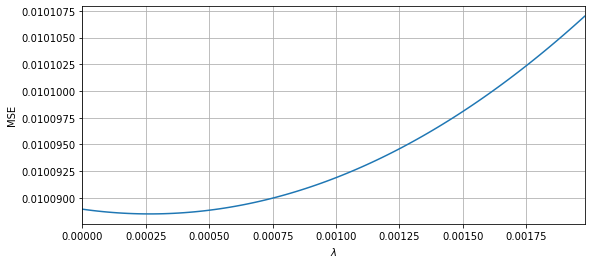

In [72]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.002, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.xlabel("$\lambda$")
    plt.ylabel("MSE")
    plt.show()



X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)



build_plot(X_train, y_train, X_val, y_val)

### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [30]:
def read_data(path="boston.csv", normilaze=True):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    if normilaze:
        dataframe = normalize(dataframe, norm='l2')
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]

    return X, y

X, y = read_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=False)

In [69]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
coeff_norm = regr.w
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 4.528173228014384e-08, R2: 0.9564156764913224


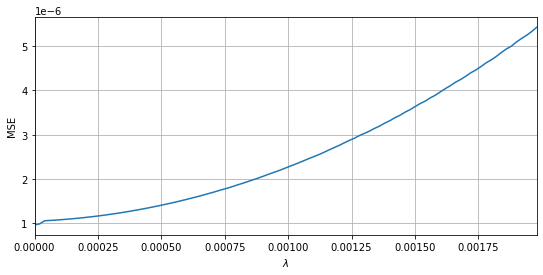

In [34]:
build_plot(X_train, y_train, X_val, y_val)

In [37]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 9.67280059005466e-07, R2: 0.06897892610717393


### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

In [114]:
features = !head -n 14  boston.csv
k = 1
for i, j in zip(coeff[1:], features):
    print(k,  round(i, 6)," ", *j.split()[2:])
    k += 1

1 -0.281928   crim per capita crime rate by town
2 -0.064403   zn proportion of residential land zoned for lots over 25,000 sq.ft.
3 0.145702   indus proportion of non-retail business acres per town
4 -0.677404   chas Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5 13.326986   nox nitric oxides concentration (parts per 10 million)
6 -3.841   rm average number of rooms per dwelling
7 0.083466   age proportion of owner-occupied units built prior to 1940
8 1.307446   dis weighted distances to five Boston employment centres
9 0.18324   rad index of accessibility to radial highways
10 -0.041291   tax full-value property-tax rate per $10,000
11 0.342094   ptratio pupil-teacher ratio by town
12 -0.033106   b 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13 -0.433702   lstat % lower status of the population


В целом коэффициенты получились адекватными: такие факторы как уровень преступности, налог на имущество и т д негативно влияют на стомость и коэффициенты при этих признаках имеют отрицательный знак. Однако, не совсем понятно, почему среднее количество комнат отрицательно влияет на стоимость, (хотя тут еще можно, что-то объяснить, было бы хуже, если бы нам давали квадратные метры). Любопытно, что процент домов (age), построенных до 1940, положительно влияет на стоимость. Ожидаемо, что соотношение учеников и учителей (pupil-teacher), близкость к центру (dis) и доступность скоростных трасс (rad) увеличивают стоимость и имеют положительный знак. 